In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
from collections import defaultdict
import pickle
import torch
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM


In [3]:
with open("/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_d2a45a4dd02a5e037e5954b82387e666/ReLUs/ReLUs_Clean.pkl", 'rb') as iffile:
    features = pickle.load(iffile)

In [4]:
features.keys()

dict_keys(['layer_2_0_0', 'layer_2_0_1', 'layer2_1_0', 'layer2_1_1', 'layer_3_0_0', 'layer_3_0_1', 'layer3_1_0', 'layer3_1_1', 'layer_4_0_0', 'layer_4_0_1', 'layer4_1_0', 'layer4_1_1'])

In [5]:
layer = 'layer_4_0_1'
features = features[layer]
features_matrix = None

for i in range(len(features)):
    if isinstance(features_matrix, torch.Tensor):
        features_matrix = torch.cat((features_matrix, features[i]))
    else:
        features_matrix = features[i]

features = None

In [6]:
features_matrix = torch.flatten(features_matrix, start_dim=1, end_dim=-1)

In [7]:
# Quantize
# Comput per-dimension mean

In [8]:
dim_mean = features_matrix.mean(dim=0)

In [9]:
binarized_matrix = torch.where(features_matrix >= dim_mean, torch.ones_like(features_matrix), torch.zeros_like(features_matrix))

In [10]:
features_matrix = None

In [11]:

torch.cuda.empty_cache()

In [12]:
binarized_matrix = binarized_matrix.cpu().numpy()

In [13]:


model = OneClassSVM(kernel='rbf')
model.fit(binarized_matrix)

OneClassSVM()

In [13]:
# save
#with open('/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_d2a45a4dd02a5e037e5954b82387e666/RBF/rbf_detector.pkl','wb') as f:
    #pickle.dump(model,f)

In [14]:
with open('/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_d2a45a4dd02a5e037e5954b82387e666/RBF/rbf_detector.pkl', 'rb') as f:
    model = pickle.load(f)

In [14]:
test_data = binarized_matrix[0:1000, :]

In [15]:
res = model.predict(test_data)

In [16]:
np.where(res == 1)[0].shape

(501,)

: 

# Analyzing CW generated images

In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms


In [29]:
x = torch.load("/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_d2a45a4dd02a5e037e5954b82387e666/CW/samples.pt")

In [30]:
x = x.numpy()

In [53]:
img = x[0]

In [54]:
img = img.swapaxes(0,1)
img = img.swapaxes(1,2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


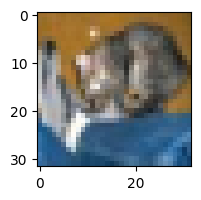

In [57]:
plt.figure(figsize = (5,2))

plt.imshow(img)

In [56]:
# Undo normalization for now
transform_test = transforms.Compose([
    transforms.ToTensor(), 
    ])


valset = torchvision.datasets.CIFAR10(root='/bigstor/zsarwar/CIFAR10', train=False,
                                    download=False, transform=transform_test
                                        )
                                    
dataloader = torch.utils.data.DataLoader(valset, batch_size=128,
                                            shuffle=False, num_workers=2)
   

In [44]:
inputs, _ = next(iter(dataloader))

In [47]:
img_r = inputs[0]
img_r = img_r.swapaxes(0,1)
img_r = img_r.swapaxes(1,2)

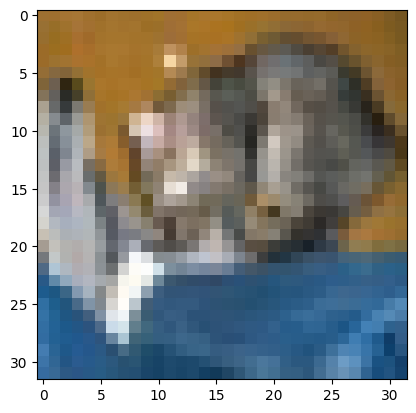

In [49]:
plt.imshow(img_r)

# Testing adv examples

In [4]:
import torch
import torch.utils.data.dataloader
import torchvision.datasets 
import torchvision.transforms as transforms

In [5]:


normalize  =  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
   

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize,   
    ])


valset = torchvision.datasets.CIFAR10(root='/bigstor/zsarwar/CIFAR10', train=False,
                                        download=False, transform=transform_test
                                        )
val_loader = torch.utils.data.DataLoader(valset, batch_size=128,
                                        shuffle=False, num_workers=2)



In [6]:
dl = iter(val_loader)


In [11]:
next(dl)

[tensor([[[[ 5.6669e-01,  3.4442e-01,  2.6503e-01,  ..., -7.1933e-01,
            -7.9871e-01, -8.3047e-01],
           [ 4.0792e-01,  1.1003e-02,  3.6029e-01,  ..., -7.3521e-01,
            -6.8758e-01, -5.6056e-01],
           [ 2.1740e-01, -3.6628e-02,  2.8091e-01,  ..., -7.5108e-01,
            -5.4469e-01, -5.7644e-01],
           ...,
           [-8.7810e-01, -8.1459e-01, -6.5582e-01,  ..., -1.3068e+00,
            -1.2909e+00, -9.8924e-01],
           [-1.1004e+00, -1.0527e+00, -7.0345e-01,  ..., -1.3703e+00,
            -1.2433e+00, -1.1321e+00],
           [-9.0985e-01, -1.0210e+00, -5.1293e-01,  ..., -1.1639e+00,
            -1.1639e+00, -1.3385e+00]],
 
          [[ 1.0819e+00,  9.6892e-01,  9.3664e-01,  ..., -3.1647e-02,
            -9.6199e-02, -1.4461e-01],
           [ 9.5278e-01,  6.3002e-01,  1.0173e+00,  ...,  3.2906e-02,
             8.1320e-02,  1.6201e-01],
           [ 7.7526e-01,  5.6546e-01,  9.2050e-01,  ...,  1.6768e-02,
             1.9429e-01,  8.1320e-02],


In [16]:
inputs_og = next(iter(val_loader))

In [15]:
adv_samples = torch.load("/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_d2a45a4dd02a5e037e5954b82387e666/CW/samples.pt")

In [33]:
input_batch = [adv_samples, inputs_og[1]]

# Random

In [2]:
import torch
from torchvision.models import resnet18

In [3]:
model = resnet18()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  